# 3rd Model training : AUTOENCODER
In this notebook we train an autoencoder to denoise our BCPPMCHURN data and feed its embeddings to an xgboost model

In [46]:
import os
#Change current directory
os.chdir ('/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn')
#Check the current directory
os.getcwd()

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
import torch
import pickle 
import json

from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [2]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

### Loading data 

------------------------

In [3]:
#Loading data
data_date = "2024-10-22"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

#transform y to array
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()
print ("------------------")
print (f"y_train length : {len(y_train)}")
print (f"y_dev length : {len(y_dev)}")
print (f"y_test length : {len(y_test)}")

x_train shape : (86992, 531)
y_train shape : (86992, 1)
------------------
x_dev shape : (14563, 531)
y_dev shape : (14563, 1)
------------------
x_test shape : (5839, 531)
y_test shape : (5839, 1)
------------------
y_train length : 86992
y_dev length : 14563
y_test length : 5839


---------------------------

### Build and train an autoencoder

Prepare data 

In [4]:
#Set seed 
np.random.seed(0)

In [5]:
def df_to_torch_tensor(df):
     """
     Transform a pandas dataframe to a torch tensor batch by batch
     """
     df_tensor_list = []
     for i in range(0,len(df), 50 ):
          if type(df) == pd.core.frame.DataFrame:
               tensor = torch.tensor(df[i:i+50].values, dtype=torch.float32)
          elif type(df) == np.ndarray:
               tensor = torch.tensor(df[i:i+50], dtype=torch.float32)

          df_tensor_list.append(tensor)
          if i%10000 == 0 and i>0:
               print (f"i = {i}, Processed 10000 points of data")
     df_tensor = torch.cat(df_tensor_list, dim=0)
     return df_tensor

In [6]:
#transform data to a pytorch tensor 
x_train_tensor = df_to_torch_tensor(x_train)
x_dev_tensor = df_to_torch_tensor(x_dev)
x_test_tensor = df_to_torch_tensor(x_test)

y_train_tensor = df_to_torch_tensor(y_train)
y_dev_tensor = df_to_torch_tensor(y_dev)
y_test_tensor = df_to_torch_tensor(y_test)

i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 10000, Processed 10000 points of data
i = 20000, Processed 10000 points of data
i = 30000, Processed 10000 points of data
i = 40000, Processed 10000 points of data
i = 50000, Processed 10000 points of data
i = 60000, Processed 10000 points of data
i = 70000, Processed 10000 points of data
i = 80000, Processed 10000 points of data
i = 10000, Processed 10000 points of data


In [8]:
def add_noise(df):
    """
    Add a guassian noise to df 
    Parameters
    ---------
    df: torch tensor
    """
    guassian_noise = torch.randn(df.shape)
    list_of_tensors = []
    for i in range(0, len(df), 50):
        if i+50 <= len(df):
            sum_tensors =  df[i:i+50] + 0.5*guassian_noise[i:i+50]
            list_of_tensors.append(sum_tensors)
        else:
            sum_tensors =  df[i:len(df)] + 0.5*guassian_noise[i:len(df)]
            list_of_tensors.append(sum_tensors)           
    df_tensor_noise = torch.cat(list_of_tensors, dim = 0)
    return df_tensor_noise

In [9]:
#add some guassian noise to data 
x_train_tensor_noise = add_noise(x_train_tensor)
x_dev_tensor_noise = add_noise(x_dev_tensor)
x_test_tensor_noise = add_noise(x_test_tensor)

In [7]:
print (x_train_tensor.shape)

torch.Size([86992, 531])


Build the autoencoder

In [8]:
#Build model
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.input_shape = input_shape
        #Multihead attention
        #self.attention = torch.nn.MultiheadAttention(embed_dim=input_shape[1], num_heads=3, batch_first=False )

        #Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape[1], input_shape[1]//2),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, 10), #TODO : try 50, 100, 
            torch.nn.ReLU()
            )
        #TODO: ADD tow layers in encoder and decoder with best bottelneck
        #Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, input_shape[1]//4),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//4, input_shape[1]//2),
            torch.nn.ReLU(),
            torch.nn.Linear(input_shape[1]//2, input_shape[1]),
        )
    
    def forward(self, x):
        #attention_output, _ = self.attention(x, x, x)
        encoding = self.encoder(x)
        output = self.decoder(encoding)
        return output 

In [104]:
#MODEL LOSS AND OPTIMIZER
eval_hist = {'train_loss': [], 'dev_loss':[]}
AUTOENCODER = Autoencoder(input_shape=x_train_tensor.shape)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.01)

In [105]:
#Model parameters
total_params = sum(p.numel() for p in AUTOENCODER.parameters())
trainable_params = sum(p.numel() for p in AUTOENCODER.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 355365
Trainable parameters: 355365


In [106]:
#Pass the autoencoder and data to GPUs
device = torch.device ("mps" if torch.backends.mps.is_available() else "cpu")
AUTOENCODER.to(device)
x_train_tensor, x_dev_tensor, x_test_tensor = x_train_tensor.to(device), x_dev_tensor.to(device), x_test_tensor.to(device)

In [145]:
#Training 
num_epochs = 200
for epoch in range(1, num_epochs+1):
    train_output = AUTOENCODER(x_train_tensor)
    train_loss = criterion(train_output, x_train_tensor)
    optimizer.zero_grad()
    train_loss.backward()
    #Optimizer
    optimizer.step()
    #DEV loss
    with torch.no_grad():
        dev_output = AUTOENCODER(x_dev_tensor)
        dev_loss = criterion(dev_output, x_dev_tensor)
    #Add loss to loss hisltory
    eval_hist["train_loss"].append(train_loss.item())
    eval_hist["dev_loss"].append(dev_loss.item())   

    #Track loss every 10 epochs 
    if (epoch)%10==0:
        print (f"epoch = [{epoch}/{num_epochs}]-------------- "
               f"train_loss : {train_loss.item():4f} ------------ "
               f"dev_loss : {dev_loss.item():4f}")

epoch = [10/200]-------------- train_loss : 519170492779724800.000000 ------------ dev_loss : 520011378656804864.000000
epoch = [20/200]-------------- train_loss : 494267104166412288.000000 ------------ dev_loss : 468842375242842112.000000
epoch = [30/200]-------------- train_loss : 479010933654421504.000000 ------------ dev_loss : 463852173000704000.000000
epoch = [40/200]-------------- train_loss : 479527738479214592.000000 ------------ dev_loss : 464717900968624128.000000
epoch = [50/200]-------------- train_loss : 477521164118261760.000000 ------------ dev_loss : 462084123943501824.000000
epoch = [60/200]-------------- train_loss : 477916679066615808.000000 ------------ dev_loss : 462918137872908288.000000
epoch = [70/200]-------------- train_loss : 514515607224320000.000000 ------------ dev_loss : 491226404759797760.000000
epoch = [80/200]-------------- train_loss : 480346943361384448.000000 ------------ dev_loss : 466940254486528000.000000
epoch = [90/200]-------------- train_los

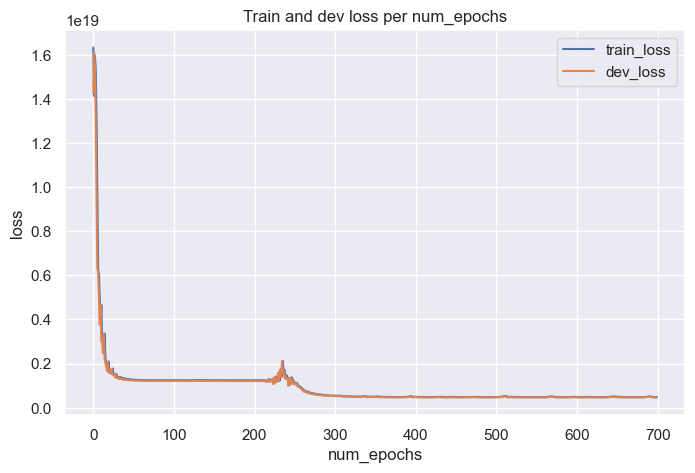

In [146]:
sns.set_theme()
plt.figure(figsize = (8, 5 ))
plt.plot(range(len(eval_hist["train_loss"])), eval_hist["train_loss"], label="train_loss")
plt.plot(range(len(eval_hist["train_loss"])), eval_hist["dev_loss"], label="dev_loss")
plt.title("Train and dev loss per num_epochs")
plt.xlabel("num_epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

The first results of training :

R2 score : -1.9627147991711744e+16

MSE : 3.389306096551199e+17

MAE : 127024152.0

In [147]:
#Test the model on test data
with torch.no_grad():
    autoencoder_test_data = AUTOENCODER(x_test_tensor)
autoencoder_test_data_numpy = autoencoder_test_data.cpu().detach().numpy()
x_test_tensor_numpy = x_test_tensor.cpu().detach().numpy()

print (f"R2 score : {r2_score(x_test_tensor_numpy, autoencoder_test_data_numpy)}") 
print (f"MSE : {mean_squared_error(x_test_tensor_numpy, autoencoder_test_data_numpy)}")
print (f"MAE : {mean_absolute_error(x_test_tensor_numpy, autoencoder_test_data_numpy)}") 

R2 score : -1393064723611648.0
MSE : 4.5325600764513485e+17
MAE : 108239352.0


Extract unoised data from original data

In [148]:
#Unoise data and transform it to numpy
columns = [f"x{i}" for i in range(1, 11)]

with torch.no_grad():
    encoded_train_data = AUTOENCODER.encoder(x_train_tensor)
    encoded_train_data = encoded_train_data.cpu().detach().numpy()
    encoded_train_data = pd.DataFrame(encoded_train_data, columns = columns)
    encoded_dev_data = AUTOENCODER.encoder(x_dev_tensor)
    encoded_dev_data = encoded_dev_data.cpu().detach().numpy()
    encoded_dev_data = pd.DataFrame(encoded_dev_data, columns = columns)
    encoded_test_data = AUTOENCODER.encoder(x_test_tensor)
    encoded_test_data = encoded_test_data.cpu().detach().numpy()
    encoded_test_data = pd.DataFrame(encoded_test_data, columns = columns)

print( f"train shape : {encoded_train_data.shape}")
print( f"dev shape : {encoded_dev_data.shape}")
print( f"test shape : {encoded_test_data.shape}")

train shape : (86992, 10)
dev shape : (14563, 10)
test shape : (5839, 10)


### Train XGBoost on encoder output data (encoded data)

In [149]:
dtrain = xgb.DMatrix(data=encoded_train_data, label=y_train_tensor)
ddev = xgb.DMatrix(data=encoded_dev_data, label=y_dev_tensor)
dtest = xgb.DMatrix(data=encoded_test_data, label=y_test_tensor)
evals = [(dtrain, "train"), (ddev, "dev")]

In [150]:
#Parameters 
params = {
    'learning_rate':0.001,
    'eta':0.1,
    'max_depth':6,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'gamma':0.1,
    'subsample': 0.9,                 
    'colsample_bytree': 1,           
    'min_child_weight': 1,     
    'scale_pos_weight': 1,   
}

In [151]:
#Initialize and train model
xgb_eval_hist = {}
XGB_MODEL = 0
XGB_MODEL = xgb.train(  params=params, 
                        dtrain=dtrain, 
                        num_boost_round=20000,
                        evals=evals,
                        early_stopping_rounds=50, 
                        evals_result=xgb_eval_hist, 
                        verbose_eval=True
                     )

[0]	train-logloss:0.69285	dev-logloss:0.69285
[1]	train-logloss:0.69256	dev-logloss:0.69257
[2]	train-logloss:0.69227	dev-logloss:0.69229
[3]	train-logloss:0.69198	dev-logloss:0.69200
[4]	train-logloss:0.69169	dev-logloss:0.69172
[5]	train-logloss:0.69140	dev-logloss:0.69144
[6]	train-logloss:0.69111	dev-logloss:0.69117
[7]	train-logloss:0.69082	dev-logloss:0.69089
[8]	train-logloss:0.69053	dev-logloss:0.69061
[9]	train-logloss:0.69025	dev-logloss:0.69033
[10]	train-logloss:0.68996	dev-logloss:0.69005
[11]	train-logloss:0.68968	dev-logloss:0.68978
[12]	train-logloss:0.68939	dev-logloss:0.68950
[13]	train-logloss:0.68911	dev-logloss:0.68922
[14]	train-logloss:0.68882	dev-logloss:0.68895
[15]	train-logloss:0.68854	dev-logloss:0.68867
[16]	train-logloss:0.68826	dev-logloss:0.68840
[17]	train-logloss:0.68798	dev-logloss:0.68813
[18]	train-logloss:0.68770	dev-logloss:0.68786
[19]	train-logloss:0.68742	dev-logloss:0.68758
[20]	train-logloss:0.68713	dev-logloss:0.68731
[21]	train-logloss:0.68

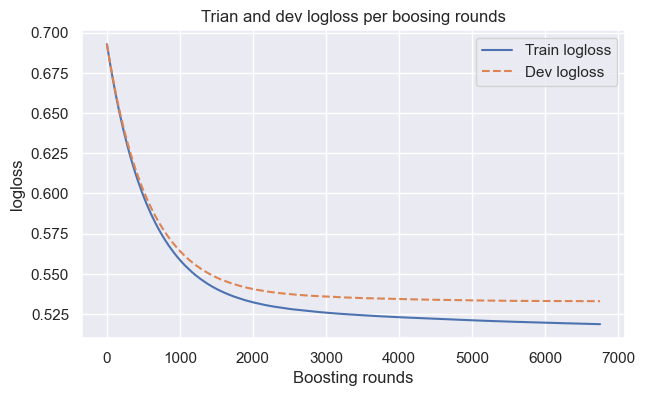

In [152]:
#Plot eval metric
utils.vis_training_metric(xgb_eval_hist, eval_metric="logloss")

In [153]:
#Predictions
y_test_predicted_prob = XGB_MODEL.predict(dtest)
y_train_predicted_prob = XGB_MODEL.predict(dtrain)
#Transform probas into predictions
THRESHOLD = 0.5
y_test_pred = [int(y_test_predicted_prob[i]>THRESHOLD) for i in range(len(y_test_predicted_prob))]
y_train_pred = [int(y_train_predicted_prob[i]>THRESHOLD) for i in range(len(y_train_predicted_prob))]

                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy    : 0.7596675556372999  ||  0.7564651481418051
xgboost precision   : 0.8157887444927817  ||  0.8171548117154812
xgboost recall      : 0.6737070938215103  ||  0.6647379169503064
xgboost f1 score    : 0.7379713995663563  ||  0.7331081081081081
-------------------------------------------------------------


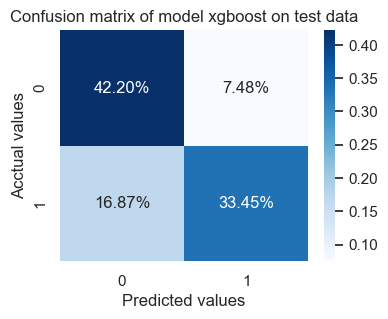

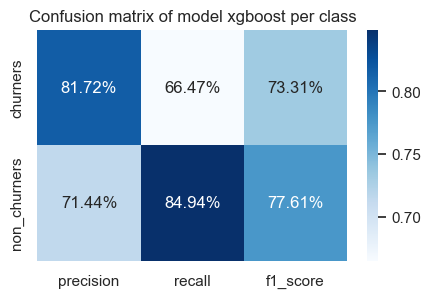

In [154]:
#Visualize model performance
utils.report_model_performances(y_train, y_train_pred, y_test, y_test_pred, model_name = "xgboost")

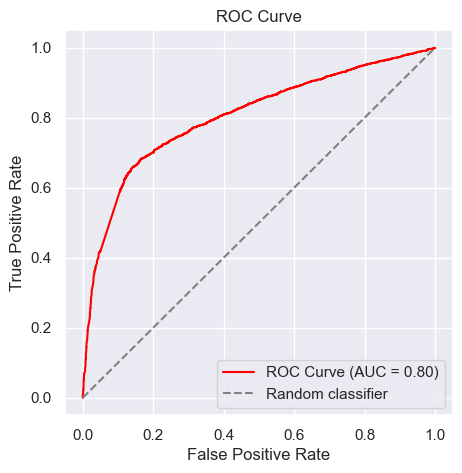

In [155]:
#Plot roc curve 
utils.vis_roc_curve(y_test, y_test_predicted_prob)

Ploting data distribution


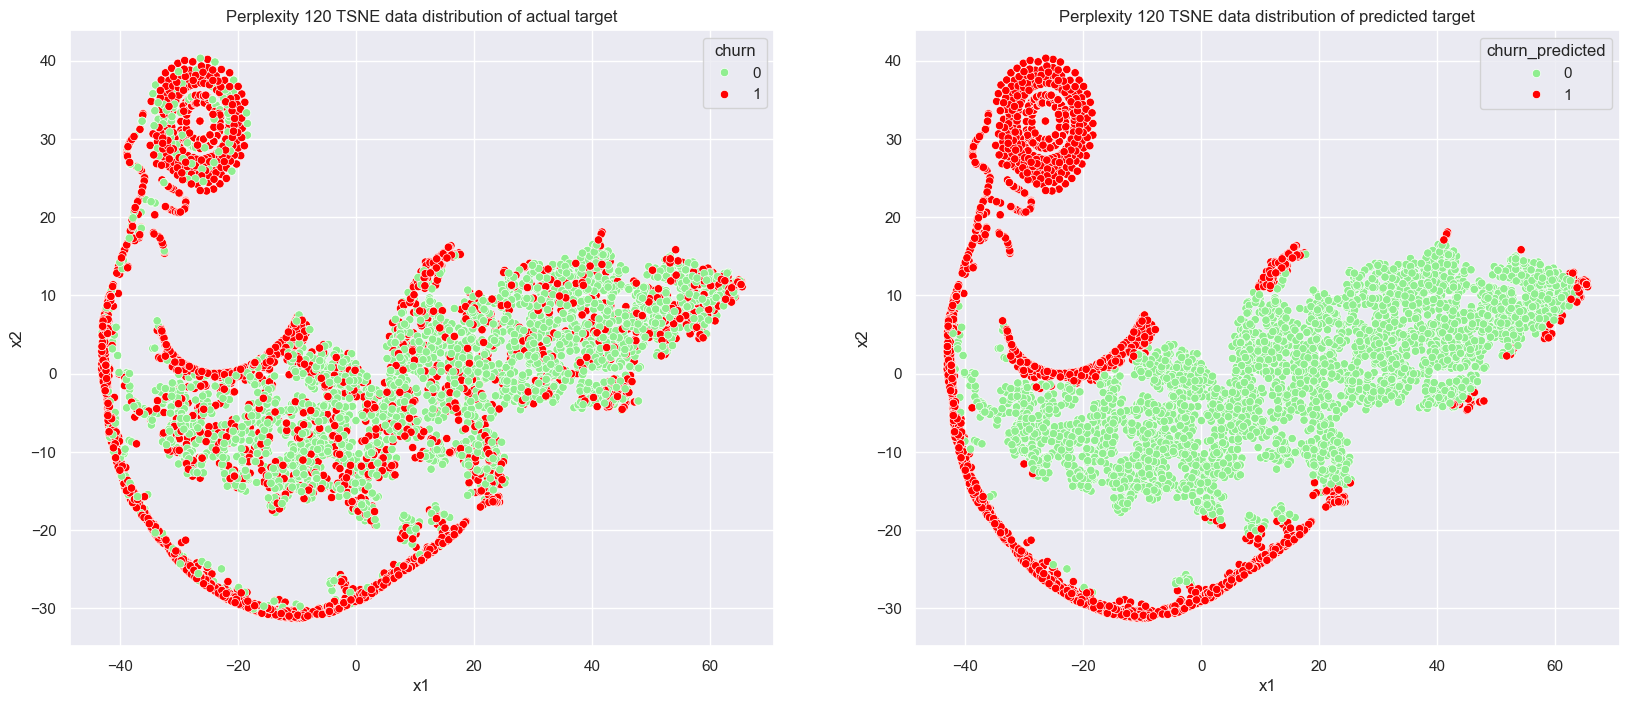

In [156]:
#Apply tsne for data distribution visualization
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components = 2, perplexity = 120).fit_transform(encoded_test_data)
data_tsne = pd.DataFrame(data_tsne, columns = ["x1", "x2"])
data_tsne["churn"] = y_test
data_tsne["churn_predicted"] = y_test_pred

#Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10*2, 8))
#Plot
print ("Ploting data distribution")
sns.set_theme()
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn", ax=axes[0], palette=["lightgreen", "red"])
axes[0].set_title("Perplexity 120 TSNE data distribution of actual target")
sns.scatterplot(data = data_tsne, x="x1", y="x2", hue = "churn_predicted", ax=axes[1], palette=["lightgreen", "red"])
axes[1].set_title("Perplexity 120 TSNE data distribution of predicted target")
plt.show()

### Check original data and denoised data

Applying tsne on data
Ploting data distribution


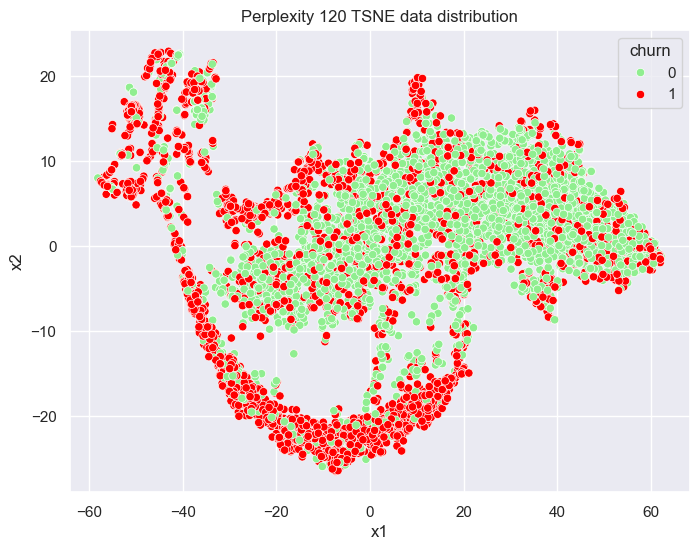

In [31]:
utils.vis_tsne_data_distribution(data=x_test, target=y_test, perplexity=120, figsize=(8, 6), palette=["lightgreen", "red"])

In [ ]:
utils.vis_tsne_data_distribution(data=encoded_test_data, target=y_test, perplexity=120, figsize=(8, 6), palette=["lightgreen", "red"])

In [51]:
test_noised_data =  x_test_tensor_noise.detach().numpy()
test_noised_data = pd.DataFrame(test_noised_data, columns = x_test.columns)

In [ ]:
utils.vis_tsne_data_distribution(data=test_noised_data, target=y_test, perplexity=120, figsize=(8, 6), palette=["lightgreen", "red"])

### Run this cell if kernel crashes when training the autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Step 1: Simulate some sample data for F1, F2, and F3
# We simulate 1000 samples
np.random.seed(0)
F1 = np.random.normal(10, 2, 1000)  # mean=10, std=2
F2 = np.random.normal(20, 5, 1000)  # mean=20, std=5
F3 = np.random.normal(30, 1, 1000)  # mean=30, std=1

# Stack them into a dataset
data = np.stack([F1, F2, F3], axis=1)
data = torch.tensor(data, dtype=torch.float32)

# Step 2: Add artificial noise to create noisy data for training
noise = 0.5 * torch.randn(data.size())
noisy_data = data + noise

# Step 3: Define a simple denoising autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(3, 2),  # Reducing from 3 to 2 dimensions
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3)  # Reconstructing back to original 3 dimensions
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = DenoisingAutoencoder()
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(noisy_data)
    loss = criterion(output, data)  # Compare output to original, clean data
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')